In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!unzip /content/drive/MyDrive/mini-project-1.zip >> /dev/null

replace mini-project-1/datasets/train/train_feature.npz? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Total Parameters: 3417
Trainable Parameters: 3417
Non-trainable Parameters: 0

Percentage of Training Data: 20%
Validation Accuracy: 0.8937, Validation Loss: 0.2942

Percentage of Training Data: 40%
Validation Accuracy: 0.9509, Validation Loss: 0.1052

Percentage of Training Data: 60%
Validation Accuracy: 0.9673, Validation Loss: 0.0802

Percentage of Training Data: 80%
Validation Accuracy: 0.9652, Validation Loss: 0.0682

Percentage of Training Data: 100%
Validation Accuracy: 0.9673, Validation Loss: 0.0618



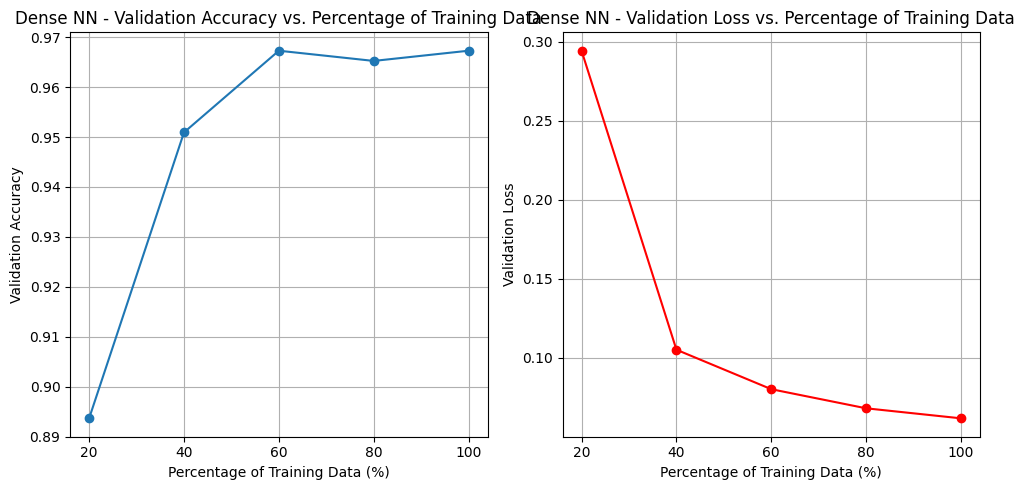

Model saved as 'dense_model.h5'.
Tokenizer saved as 'tokenizer.pkl'.


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import pickle  # Importing pickle to save the tokenizer

# Load the datasets
train_emoticon_df = pd.read_csv("/content/mini-project-1/datasets/train/train_emoticon.csv")
valid_emoticon_df = pd.read_csv("/content/mini-project-1/datasets/valid/valid_emoticon.csv")
test_emoticon_df = pd.read_csv("/content/mini-project-1/datasets/test/test_emoticon.csv")

# Prepare train and validation data
train_emoticon_X = train_emoticon_df['input_emoticon'].tolist()
train_emoticon_Y = train_emoticon_df['label'].tolist()

valid_emoticon_X = valid_emoticon_df['input_emoticon'].tolist()
valid_emoticon_Y = valid_emoticon_df['label'].tolist()

# Convert labels to NumPy arrays of integers
train_emoticon_Y = np.array(train_emoticon_Y).astype(int)
valid_emoticon_Y = np.array(valid_emoticon_Y).astype(int)

# Create a tokenizer
tokenizer = Tokenizer(char_level=True)  # Using char-level tokenization for emojis
tokenizer.fit_on_texts(train_emoticon_X)

# Encode and pad the sequences for training data
train_sequences = tokenizer.texts_to_sequences(train_emoticon_X)
max_len = max(len(seq) for seq in train_sequences)  # Maximum length for padding
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post')

# Encode and pad the sequences for validation data
valid_sequences = tokenizer.texts_to_sequences(valid_emoticon_X)
valid_padded = pad_sequences(valid_sequences, maxlen=max_len, padding='post')

# Function to build a Dense Neural Network model
def build_dense_model():
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=8, input_length=max_len))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification
    return model

# Build the Dense NN model
model = build_dense_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, max_len))


# Extract parameters
total_params = model.count_params()
trainable_params = np.sum([K.count_params(p) for p in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")
print(f"Non-trainable Parameters: {non_trainable_params}\n")

# Initialize lists to store results
percentages = [20, 40, 60, 80, 100]
accuracies = []
val_losses = []

# Loop over percentages of training data
for percent in percentages:
    n_samples = int(len(train_emoticon_X) * percent / 100)
    train_subset_X = train_emoticon_X[:n_samples]
    train_subset_Y = train_emoticon_Y[:n_samples]

    # Tokenize and pad sequences
    train_sequences = tokenizer.texts_to_sequences(train_subset_X)
    train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post')

    # Train the model on the subset
    history = model.fit(train_padded, train_subset_Y, epochs=10, batch_size=32, verbose=0, validation_data=(valid_padded, valid_emoticon_Y))

    # Store accuracies and losses
    val_accuracy = history.history['val_accuracy'][-1]
    val_loss = history.history['val_loss'][-1]
    accuracies.append(val_accuracy)
    val_losses.append(val_loss)

    print(f"Percentage of Training Data: {percent}%")
    print(f"Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}\n")

# Plot the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(percentages, accuracies, marker='o')
plt.title('Dense NN - Validation Accuracy vs. Percentage of Training Data')
plt.xlabel('Percentage of Training Data (%)')
plt.ylabel('Validation Accuracy')
plt.xticks(percentages)
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(percentages, val_losses, marker='o', color='r')
plt.title('Dense NN - Validation Loss vs. Percentage of Training Data')
plt.xlabel('Percentage of Training Data (%)')
plt.ylabel('Validation Loss')
plt.xticks(percentages)
plt.grid()

plt.tight_layout()
plt.show()


model.save("dense_model.h5")
print("Model saved as 'dense_model.h5'.")

# Save the tokenizer using pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
print("Tokenizer saved as 'tokenizer.pkl'.")



Model: FeatureModel
Percentage: 20.0%, Accuracy: 0.9673
Percentage: 40.0%, Accuracy: 0.9755
Percentage: 60.0%, Accuracy: 0.9796
Percentage: 80.0%, Accuracy: 0.9898
Percentage: 100.0%, Accuracy: 0.9877


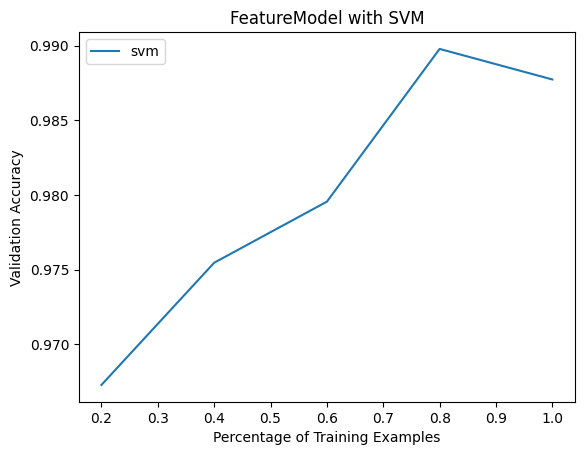

Model and scaler saved as 'svm_model.joblib' and 'scaler.joblib'.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import joblib  # For saving the model


# FeatureModel
class FeatureModel:
    def __init__(self, algorithm='svm'):
        self.scaler = StandardScaler()
        if algorithm == 'svm':
            self.model = SVC()

    def train(self, X, y):
        X = X.reshape(X.shape[0], -1)
        X = self.scaler.fit_transform(X)
        self.model.fit(X, y)

    def predict(self, X):
        X = X.reshape(X.shape[0], -1)
        X = self.scaler.transform(X)
        return self.model.predict(X)

# Read datasets
train_feat_X = np.load("/content/mini-project-1/datasets/train/train_feature.npz", allow_pickle=True)['features']
train_feat_Y = np.load("/content/mini-project-1/datasets/train/train_feature.npz", allow_pickle=True)['label']
valid_feat_X = np.load("/content/mini-project-1/datasets/valid/valid_feature.npz", allow_pickle=True)['features']
valid_feat_Y = np.load("/content/mini-project-1/datasets/valid/valid_feature.npz", allow_pickle=True)['label']

# Experiment with different percentages of training examples
percentages = [0.2, 0.4, 0.6, 0.8, 1.0]
algorithm = 'svm'
model = FeatureModel(algorithm)  # Initialize the model once

# Train and evaluate using the FeatureModel with SVM
print(f"Model: FeatureModel")
accuracy_list = []
for percentage in percentages:
    num_train_examples = int(len(train_feat_X) * percentage)
    model.train(train_feat_X[:num_train_examples], train_feat_Y[:num_train_examples])
    pred = model.predict(valid_feat_X)
    accuracy = accuracy_score(valid_feat_Y, pred)
    accuracy_list.append(accuracy)
    print(f"Percentage: {percentage * 100}%, Accuracy: {accuracy:.4f}")

# Plot the results
plt.plot(percentages, accuracy_list, label=algorithm)
plt.xlabel('Percentage of Training Examples')
plt.ylabel('Validation Accuracy')
plt.title('FeatureModel with SVM')
plt.legend()
plt.show()

# Save the trained model and scaler
joblib.dump(model.model, "svm_model.joblib")
joblib.dump(model.scaler, "scaler.joblib")
print("Model and scaler saved as 'svm_model.joblib' and 'scaler.joblib'.")


Best model saved as 'best_svm_model.pkl'.
Training Size: 20.0%
Validation Accuracy: 0.6094
----------------------------------------
Training Size: 40.0%
Validation Accuracy: 0.6401
----------------------------------------
Training Size: 60.0%
Validation Accuracy: 0.6605
----------------------------------------
Training Size: 80.0%
Validation Accuracy: 0.6626
----------------------------------------
Training Size: 100.0%
Validation Accuracy: 0.6544
----------------------------------------


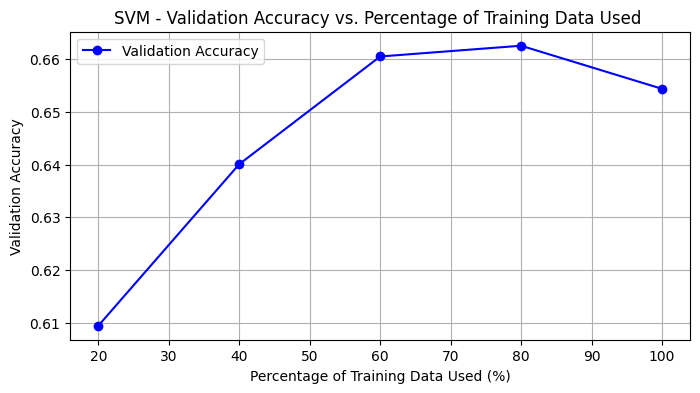

In [ ]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from google.colab import files
import joblib  # Import joblib for saving/loading the model

# Load the text sequence datasets from the uploaded files
train_textseq = pd.read_csv('/content/mini-project-1/datasets/train/train_text_seq.csv')  # Ensure the file name matches
valid_textseq = pd.read_csv('/content/mini-project-1/datasets/valid/valid_text_seq.csv')  # Ensure the file name matches
test_textseq = pd.read_csv('/content/mini-project-1/datasets/test/test_text_seq.csv')    # Ensure the file name matches

# Convert the text sequence to individual digits (splitting each string into list of integers)
X_train = train_textseq['input_str'].apply(lambda x: [int(char) for char in x]).tolist()
y_train = train_textseq['label']
X_valid = valid_textseq['input_str'].apply(lambda x: [int(char) for char in x]).tolist()
y_valid = valid_textseq['label']
X_test = test_textseq['input_str'].apply(lambda x: [int(char) for char in x]).tolist()

# Convert lists to DataFrame for ease of use
X_train = pd.DataFrame(X_train)
X_valid = pd.DataFrame(X_valid)
X_test = pd.DataFrame(X_test)

# One-Hot Encoding: Convert the digits to one-hot encoded vectors
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train)
X_valid_encoded = encoder.transform(X_valid)

# Save the encoder for later use
joblib.dump(encoder, 'onehot_encoder.pkl')

# Define the sizes of training examples to test
training_sizes = [0.2, 0.4, 0.6, 0.8, 1.0]
results = []

best_model = None
best_accuracy = 0

# Train and evaluate the model for each training size
for size in training_sizes:
    # Determine the number of samples to use for training
    n_samples = int(size * len(X_train_encoded))

    # Create training and validation sets based on the current size
    X_train_subset = X_train_encoded[:n_samples]
    y_train_subset = y_train[:n_samples]

    # Train the SVM model
    model = SVC(C=2, kernel='linear', gamma='scale')  # Using the tuned parameters
    model.fit(X_train_subset, y_train_subset)

    # Evaluate the model on the validation set
    y_pred_valid = model.predict(X_valid_encoded)
    validation_accuracy = accuracy_score(y_valid, y_pred_valid)

    # Store the results
    results.append({
        'Training Size (%)': size * 100,
        'Validation Accuracy': validation_accuracy,
    })

    # Check if this model is the best so far
    if validation_accuracy > best_accuracy:
        best_accuracy = validation_accuracy
        best_model = model  # Save the best model

# Save the best model to a file
if best_model is not None:
    joblib.dump(best_model, 'best_svm_model.pkl')
    print("Best model saved as 'best_svm_model.pkl'.")

# Display the results
for result in results:
    print(f"Training Size: {result['Training Size (%)']}%")
    print(f"Validation Accuracy: {result['Validation Accuracy']:.4f}")
    print("-" * 40)

# Plot the graph: Validation Accuracy vs. Percentage of Training Data Used
training_sizes = [result['Training Size (%)'] for result in results]
validation_accuracies = [result['Validation Accuracy'] for result in results]

plt.figure(figsize=(8, 4))
plt.plot(training_sizes, validation_accuracies, marker='o', linestyle='-', color='b', label='Validation Accuracy')
plt.title('SVM - Validation Accuracy vs. Percentage of Training Data Used ')
plt.xlabel('Percentage of Training Data Used (%)')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

# Load datasets
train_emoticon_df = pd.read_csv('/content/mini-project-1/datasets/train/train_emoticon.csv')
valid_emoticon_df = pd.read_csv('/content/mini-project-1/datasets/valid/valid_emoticon.csv')
train_embedding_df = pd.read_csv('/content/mini-project-1/datasets/train/train_text_seq.csv')
valid_embedding_df = pd.read_csv('/content/mini-project-1/datasets/valid/valid_text_seq.csv')

# Prepare data
train_emoticon_X = train_emoticon_df['input_emoticon'].tolist()
valid_emoticon_X = valid_emoticon_df['input_emoticon'].tolist()
train_Y = train_emoticon_df['label'].tolist()
valid_Y = valid_emoticon_df['label'].tolist()

# Load text data
train_text_X = np.load('/content/mini-project-1/datasets/train/train_feature.npz')['features']
valid_text_X = np.load('/content/mini-project-1/datasets/valid/valid_feature.npz')['features']

# Convert NumPy arrays to lists of strings
train_text_X = [' '.join(map(str, sublist)) if isinstance(sublist, list) else str(sublist) for sublist in train_text_X]
valid_text_X = [' '.join(map(str, sublist)) if isinstance(sublist, list) else str(sublist) for sublist in valid_text_X]

# Initialize tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(train_emoticon_X + train_text_X)

# Pad sequences for emoticons
train_emoticon_sequences = tokenizer.texts_to_sequences(train_emoticon_X)
valid_emoticon_sequences = tokenizer.texts_to_sequences(valid_emoticon_X)
max_len_emoticon = max(len(seq) for seq in train_emoticon_sequences)
train_emoticon_padded = pad_sequences(train_emoticon_sequences, maxlen=max_len_emoticon, padding='post')
valid_emoticon_padded = pad_sequences(valid_emoticon_sequences, maxlen=max_len_emoticon, padding='post')

# Process text sequences
train_text_sequences = tokenizer.texts_to_sequences(train_text_X)
valid_text_sequences = tokenizer.texts_to_sequences(valid_text_X)
max_len_text = max(len(seq) for seq in train_text_sequences + valid_text_sequences)
train_text_padded = pad_sequences(train_text_sequences, maxlen=max_len_text, padding='post')
valid_text_padded = pad_sequences(valid_text_sequences, maxlen=max_len_text, padding='post')

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(((train_emoticon_padded, train_text_padded), train_Y))
valid_dataset = tf.data.Dataset.from_tensor_slices(((valid_emoticon_padded, valid_text_padded), valid_Y))

# Shuffle and batch
train_dataset = train_dataset.shuffle(1000).batch(8)  # Batch size remains the same
valid_dataset = valid_dataset.batch(8)

# Model definition
emoticon_input = Input(shape=(max_len_emoticon,), name='emoticon_input')
text_input = Input(shape=(max_len_text,), name='text_input')

# Emoticon branch
emoticon_embedding = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=6)(emoticon_input)  # Reduced embedding size
emoticon_lstm = Bidirectional(LSTM(14))(emoticon_embedding)  # Increased LSTM units
emoticon_lstm = Dropout(0.3)(emoticon_lstm)  # Reduced dropout for better learning

# Text branch
text_embedding = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=6)(text_input)  # Reduced embedding size
text_lstm = Bidirectional(LSTM(14))(text_embedding)  # Increased LSTM units
text_lstm = Dropout(0.3)(text_lstm)  # Reduced dropout for better learning

# Concatenate branches
concatenated = Concatenate()([emoticon_lstm, text_lstm])

# Final layers
dense_out = Dense(16, activation='relu')(concatenated)  # Smaller Dense layer
dense_out = Dropout(0.4)(dense_out)  # Dropout to avoid overfitting
output = Dense(1, activation='sigmoid')(dense_out)

# Compile model with a slightly higher learning rate
model = Model(inputs=[emoticon_input, text_input], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=10
)

# Save the trained model
model.save('combined_model.h5')

# Evaluate the model
val_loss, val_accuracy = model.evaluate(valid_dataset)
print(f"Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}")

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1/10
144/885 ━━━━━━━━━━━━━━━━━━━━ 4:50 392ms/step - accuracy: 0.4980 - loss: 0.6933

KeyboardInterrupt: 

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate, Flatten, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

# Load datasets
train_emoticon_df = pd.read_csv('/content/mini-project-1/datasets/train/train_emoticon.csv')
valid_emoticon_df = pd.read_csv('/content/mini-project-1/datasets/valid/valid_emoticon.csv')
train_deep_features = np.load('/content/mini-project-1/datasets/train/train_feature.npz')
valid_deep_features = np.load('/content/mini-project-1/datasets/valid/valid_feature.npz')
train_text_df = pd.read_csv('/content/mini-project-1/datasets/train/train_text_seq.csv')
valid_text_df = pd.read_csv('/content/mini-project-1/datasets/valid/valid_text_seq.csv')

# Extract the data from datasets
train_emoticon_X = train_emoticon_df['input_emoticon'].tolist()
train_emoticon_Y = train_emoticon_df['label'].tolist()

# Deep Features
train_deep_features_X = train_deep_features['features']  # shape (N, 13, 786)
train_deep_features_Y = train_deep_features['label'].tolist()

# Text Sequence Data
train_text_X = train_text_df['input_str'].tolist()  # Corrected column name
train_text_Y = train_text_df['label'].tolist()

# Validation sets (for all three datasets)
valid_emoticon_X = valid_emoticon_df['input_emoticon'].tolist()
valid_emoticon_Y = valid_emoticon_df['label'].tolist()

valid_deep_features_X = valid_deep_features['features']  # shape (N, 13, 786)
valid_deep_features_Y = valid_deep_features['label'].tolist()

valid_text_X = valid_text_df['input_str'].tolist()
valid_text_Y = valid_text_df['label'].tolist()

# Tokenizer for text data (character-level tokenization)
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(train_text_X + train_emoticon_X)

# Pad emoticon data
emoticon_sequences = tokenizer.texts_to_sequences(train_emoticon_X)
max_len_emoticon = max(len(seq) for seq in emoticon_sequences)
emoticon_padded = pad_sequences(emoticon_sequences, maxlen=max_len_emoticon, padding='post')

# Process the deep features - you can either flatten or pass them through a layer
deep_features_padded = np.array([np.mean(features, axis=0) for features in train_deep_features_X])  # Averaging

# Pad text sequences
text_sequences = tokenizer.texts_to_sequences(train_text_X)
max_len_text = max(len(seq) for seq in text_sequences)
text_padded = pad_sequences(text_sequences, maxlen=max_len_text, padding='post')

# Convert labels to numpy arrays
train_labels = np.array(train_emoticon_Y)

# Preprocess the validation data
# Emoticon
valid_emoticon_sequences = tokenizer.texts_to_sequences(valid_emoticon_X)
valid_emoticon_padded = pad_sequences(valid_emoticon_sequences, maxlen=max_len_emoticon, padding='post')

# Deep features
valid_deep_features_padded = np.array([np.mean(features, axis=0) for features in valid_deep_features_X])

# Text sequences
valid_text_sequences = tokenizer.texts_to_sequences(valid_text_X)
valid_text_padded = pad_sequences(valid_text_sequences, maxlen=max_len_text, padding='post')

valid_labels = np.array(valid_emoticon_Y)  # Using the same labels as the emoticons

# Create TensorFlow datasets for training
train_dataset = tf.data.Dataset.from_tensor_slices(((emoticon_padded, deep_features_padded, text_padded), train_labels))
train_dataset = train_dataset.shuffle(1000).batch(8)  # Batch size can be adjusted

# Create TensorFlow dataset for validation
valid_dataset = tf.data.Dataset.from_tensor_slices(((valid_emoticon_padded, valid_deep_features_padded, valid_text_padded), valid_labels))
valid_dataset = valid_dataset.batch(8)

# Define the model
def create_combined_model(max_len_emoticon, max_len_text, deep_feature_size):
    # Emoticon Input Branch
    emoticon_input = Input(shape=(max_len_emoticon,), name='emoticon_input')
    emoticon_embedding = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=6)(emoticon_input)
    emoticon_lstm = Bidirectional(LSTM(8))(emoticon_embedding)
    emoticon_lstm = Dropout(0.3)(emoticon_lstm)

    # Deep Features Input Branch
    deep_features_input = Input(shape=(deep_feature_size,), name='deep_features_input')
    deep_features_dense = Dense(6, activation='relu')(deep_features_input)
    deep_features_dense = Dropout(0.3)(deep_features_dense)

    # Text Sequence Input Branch
    text_input = Input(shape=(max_len_text,), name='text_input')
    text_embedding = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=6)(text_input)
    text_lstm = Bidirectional(LSTM(8))(text_embedding)
    text_lstm = Dropout(0.3)(text_lstm)

    # Concatenate the outputs from the three branches
    concatenated = Concatenate()([emoticon_lstm, deep_features_dense, text_lstm])

    # Fully connected layers
    dense_out = Dense(8, activation='relu')(concatenated)
    dense_out = Dropout(0.4)(dense_out)
    output = Dense(1, activation='sigmoid')(dense_out)

    # Compile the model
    model = Model(inputs=[emoticon_input, deep_features_input, text_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Best model and accuracy tracking
best_model = None
best_accuracy = 0.0

# Train and validate using different training sizes
training_sizes = []
validation_accuracies = []

# Train using varying amounts of training data (20%, 40%, 60%, 80%, 100%)
train_sizes = [0.2, 0.4, 0.6, 0.8, 1.0]

for size in train_sizes:
    dataset_size = int(size * len(train_labels))

    # Shuffle and select a random subset of the data for each training size
    subset = train_dataset.shuffle(1000).take(dataset_size)  # Shuffle before taking the subset

    # Print the percentage of data used for training
    print(f"\nTraining with {size * 100:.0f}% of the data ({dataset_size} samples)")

    # Re-initialize the model for each subset training
    model = create_combined_model(max_len_emoticon, max_len_text, 768)  # Reset the model for each subset

    # Save the best model during training

    checkpoint_callback = ModelCheckpoint(
        filepath=f'best_model_{size:.1f}.keras',  # Use f-string formatting here
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    # Train the model on this subset
    history = model.fit(
        subset,
        validation_data=valid_dataset,  # Use the validation dataset for evaluation
        epochs=10,
        callbacks=[checkpoint_callback],  # Pass the checkpoint callback to save the best model
        verbose=1  # Show training progress
    )

    # Evaluate the model and check if it is the best one so far
    val_acc = max(history.history['val_accuracy'])  # Get the maximum validation accuracy from the current training
    validation_accuracies.append(val_acc)

    # Compare with best accuracy and update if this model is better
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_model = model  # Save the best model
        # Save the best model to a file
        model.save('best_combined_model.keras')  # Save the overall best model

# Plot accuracy vs training set size in percentages
training_percentages = [20, 40, 60, 80, 100]  # Corresponding to the 20%, 40%, 60%, 80%, 100% of data used

plt.plot(training_percentages, validation_accuracies, marker='o')
plt.xlabel('Training Set Size (%)')
plt.ylabel('Validation Accuracy')
plt.title('Accuracy vs Training Set Size (%)')
plt.grid(True)
plt.xticks(training_percentages)
plt.show()



Training with 20% of the data (1416 samples)
Epoch 1/10
872/885 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5393 - loss: 0.6830

KeyboardInterrupt: 